In [1]:
#import utils as ut
import utils_loc as ut
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input, Activation, SeparableConv2D, BatchNormalization, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

from keras.layers import concatenate as concatenate
#from keras.layers.merge import concatenate

from keras.callbacks import EarlyStopping, ModelCheckpoint

import time
inicio = time.time()

2022-06-24 18:14:11.760076: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/erick/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-06-24 18:14:11.760102: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#DATADIR1 = '../../../_DATA_/_DATA/ORIGINAL_GOLD/Original'
#DATADIR2 = '../../../_DATA_/_DATA/ORIGINAL_GOLD/GOLD'
#TESTDIR = '../../../_DATA_/_DATA/ORIGINAL'

DATADIR1 = '../../../_DATA_/_DATA/AUG/flip/ORIGINAL'
DATADIR1 = pathlib.Path(DATADIR1)

DATADIR2 = '../../../_DATA_/_DATA/AUG/flip/GOLD'
DATADIR2 = pathlib.Path(DATADIR2)

TESTDIR = '../../../_DATA_/_DATA/ORIGINAL'

In [3]:
proportion = 1.77777777778 # 16:9
k = 4#k*32 menor dimensão da imagem (arrendondada)
IMG_CHANNELS = 3
EPOCHS = 150
batch_size = 64
save_model = True
patience = 10#no improvement patience

height = int(np.around((k * proportion), decimals=0).astype('int') * 32) # too low can cause dimension error and must be divisible by 32
width = int(k * 32)# too low can cause dimension error and must be divisible by 32
IMG_WIDTH_HEIGHT = max(height, width)

original,_ = ut.read_imgs(path=DATADIR1, height=height, width=width, resize = True, mode = 'RGB', squared = True, square_color=(255,255,255), show = False, write=False, write_path='original')

gold_masks,_ = ut.read_imgs(path=DATADIR2, height=height, width=width, resize = True, mode = 'GRAYSCALE', squared = True, square_color=(0,0,0), show = False, write=False, write_path='gold_masks')

test,_ = ut.read_imgs(path=TESTDIR, height=height, width=width, resize = True, mode = 'RGB', squared = True, square_color=(255,255,255), show = False, write=False, write_path='test')

100%|██████████| 66/66 [00:00<00:00, 137.18it/s]


In [4]:
X_train = []
Y_train = []
X_test = []
for image, mask in ut.concatenate2_2_it(original, gold_masks):

        X_train.append(image.astype('float32') / 255.0)
        #plt.imshow(X_train[-1], cmap='gray')
        #plt.show()
        
        aux = mask.astype('float32') / 255.0    
        Y_train.append( np.around(aux, decimals=0).astype('uint8') )
        #plt.imshow(Y_train[-1], cmap='gray')
        #plt.show()

for test_img in test:

        X_test.append(test_img.astype('float32') / 255.0)
        #plt.imshow(X_test[-1], cmap='gray')
        #plt.show()

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)

In [5]:
def convolutional_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)
   
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
  
    else:
        next_layer = conv
        
    #conv = BatchNormalization()(conv)
    skip_connection = conv
    
    return next_layer, skip_connection

In [6]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)

    merge = concatenate([up, contractive_input], axis=3)# ??????????????????????????---------------

    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    return conv

In [7]:
def unet_model(input_size=(IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT
                           , IMG_CHANNELS), n_filters=32, n_classes=3):
    
    inputs = Input(input_size)
    
    #contracting path
    cblock1 = convolutional_block(inputs, n_filters)
    cblock2 = convolutional_block(cblock1[0], 2*n_filters)
    cblock3 = convolutional_block(cblock2[0], 4*n_filters)
    cblock4 = convolutional_block(cblock3[0], 8*n_filters, dropout_prob=0.2) 
    cblock5 = convolutional_block(cblock4[0],16*n_filters, dropout_prob=0.2, max_pooling=None)     
    
    #expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)
    conv9 = Conv2D(n_classes,
                 1,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    #conv10 = Conv2D(n_classes, kernel_size=1, padding='same', activation = 'softmax')(conv9) 
    conv10 = Activation('softmax')(conv9)
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

2022-06-24 18:16:18.042042: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/erick/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-06-24 18:16:18.042076: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-24 18:16:18.042106: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lasid30): /proc/driver/nvidia/version does not exist
2022-06-24 18:16:18.042412: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


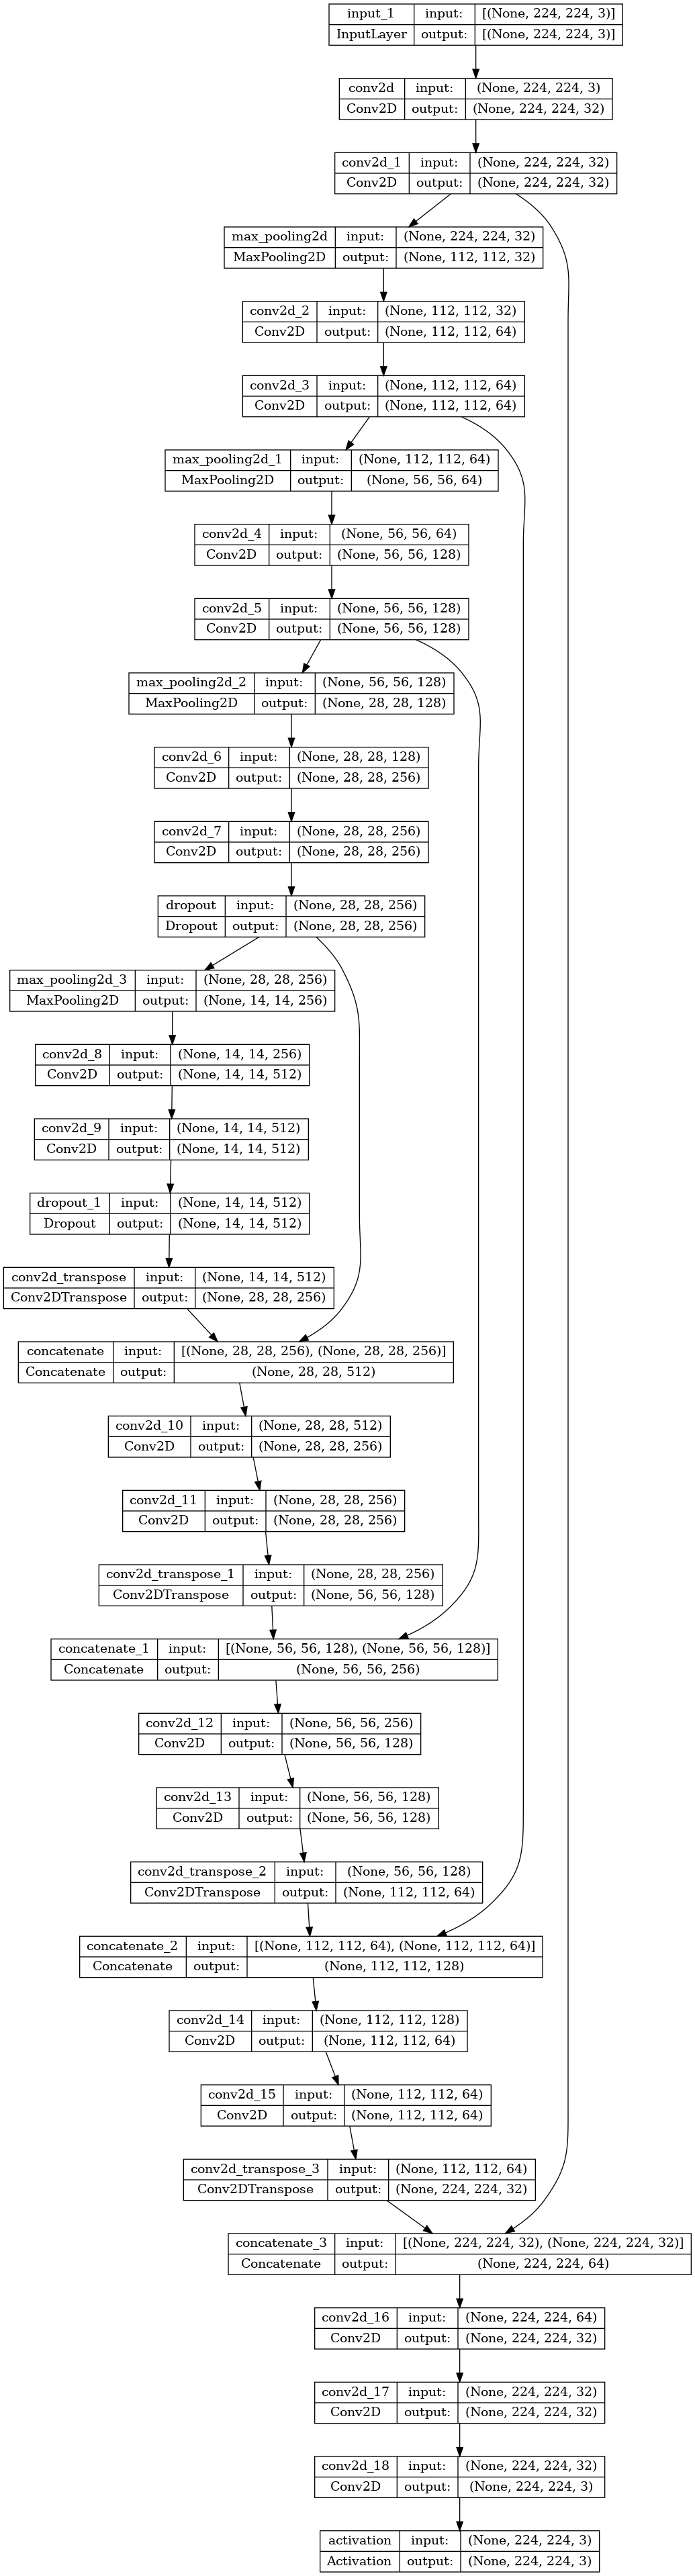

In [8]:
unet = unet_model((IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, IMG_CHANNELS), n_classes=3)
tf.keras.utils.plot_model(unet, show_shapes=True)

In [ ]:
unet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True, verbose=0)
model_history = unet.fit(X_train, Y_train, batch_size=batch_size, epochs=EPOCHS, callbacks=[earlystopper])

Epoch 1/150
22/22 [==============================] - 426s 19s/step - loss: 1.1142 - accuracy: 0.7905
Epoch 2/150
22/22 [==============================] - 419s 19s/step - loss: 0.4921 - accuracy: 0.8482
Epoch 3/150
22/22 [==============================] - 418s 19s/step - loss: 0.4231 - accuracy: 0.8482
Epoch 4/150
22/22 [==============================] - 419s 19s/step - loss: 0.4176 - accuracy: 0.8482
Epoch 5/150
22/22 [==============================] - 418s 19s/step - loss: 0.4086 - accuracy: 0.8482
Epoch 6/150
22/22 [==============================] - 418s 19s/step - loss: 0.4005 - accuracy: 0.8482
Epoch 7/150
22/22 [==============================] - 417s 19s/step - loss: 0.3912 - accuracy: 0.8482
Epoch 8/150
22/22 [==============================] - 418s 19s/step - loss: 0.3889 - accuracy: 0.8482
Epoch 9/150
22/22 [==============================] - 423s 19s/step - loss: 0.3841 - accuracy: 0.8482
Epoch 10/150
22/22 [==============================] - 417s 19s/step - loss: 0.3834 - accura

In [ ]:
train_predictions = unet.predict(X_train)
test_predictions = unet.predict(X_test)

In [ ]:
from skimage.filters import try_all_threshold
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

In [ ]:
for i in range(len(train_predictions)):

    # making subplots
    fig, ax = plt.subplots(1, 3)

    # set data with subplots and plot  
    ax[0].imshow(X_train[i])
    ax[0].set_title('Original')
    
    ax[1].imshow(Y_train[i], cmap='gray')
    ax[1].set_title('Gold Mask')
    
    grays = rgb2gray(train_predictions[i])
    thresh = threshold_otsu( grays )    
    binary = grays > thresh

    ax[2].imshow(binary, cmap='gray')
    ax[2].set_title('Predicted Mask')

    fig.tight_layout()
    plt.show()


In [ ]:
for i in range(len(test_predictions)):

    # making subplots
    fig, ax = plt.subplots(1, 2)

    # set data with subplots and plot  
    ax[0].imshow(X_test[i])
    ax[0].set_title('Original')
    
    grays = rgb2gray(test_predictions[i])
    thresh = threshold_otsu( grays )    
    binary = grays > thresh

    ax[1].imshow(binary, cmap='gray')
    ax[1].set_title('Predicted Mask')

    fig.tight_layout()
    #plt.show()

In [ ]:
if save_model:
    nome_saida = f'models/model+aug-k={k}.h5'
    #nome_saida = caminho_modelo+nome+'.h5'
    unet.save(nome_saida)
    print('Salvo como: ',nome_saida)
print('Tempo de execução: ', time.time() - inicio)

In [ ]:
colunas = ['Original file name', 'area_em_pixels', 'altura_em_pixels', 'largura_em_pixels','IOU']
data = []

DATADIR1 = pathlib.Path(DATADIR1)
DATADIR1_files = os.listdir(DATADIR1)

DATADIR2 = pathlib.Path(DATADIR2)
DATADIR2_files = os.listdir(DATADIR2)

In [ ]:
for i in range(len(train_predictions)):
    
    grays = rgb2gray(train_predictions[i])
    thresh = threshold_otsu( grays )    
    binary = grays > thresh


    data.append(ut.take_area(X_test[i], DATADIR1_files[i]) + [ut.IOU(Y_train[i], binary)] )

df = pd.DataFrame(data=data, columns =colunas)
df

In [ ]:
print('Tempo de execução: ', time.time() - inicio)